# Demo:  Polynomial Model Order Selection

In this demo, we will illustrate the process of cross-validation for model order selection.  We demonstrate the concepts via  polynomial fitting using synthetic dat.  The lab will demonstrate how to:
* Characterize the model order for a simple polynomial model
* Measure training and test error for a given model order
* Select a suitable model order using cross-validation
* Plot the results for the model order selection process

We first load the packages as usual.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, preprocessing
%matplotlib inline

## Polynomial Data

To illustrate the concepts, we consider a simple polynomial model:
$$
   y = \beta_0 + \beta_1 x + \cdots + \beta_d x^d + \epsilon,
$$
where $d$ is the polynomial degree.  We first generate *synthetic* data for this model.  Sythetic data means that the data was generated artifically (e.g. by a computer program) instead of being actually measured.    

In [2]:
# Import useful polynomial library
import numpy.polynomial.polynomial as poly

# True model parameters  
beta = np.array([1,0.5,0,2])   # coefficients  包含斜率
wstd = 0.2                     # noise  噪声的标准差（standar deviation）
dtrue = len(beta)-1            # true poly degree

# Independent data
nsamp = 40
# 在均匀分布上随机取nsam（40）个点
xdat = np.random.uniform(-1,1,nsamp)

# Polynomial
# y0是真实值，size为40的数组
y0 = poly.polyval(xdat,beta)
# 给y0真实值上加上服从工正态分布的噪声
ydat = y0 + np.random.normal(0,wstd,nsamp)
# y0.shape ---（40，）
# help(poly.polyval)
# polyval(x, c, tensor=True)
# p(x) = c_0 + c_1 * x + ... + c_n * x^n
# help(np.random.normal)

If you were given the data, you would first plot the data via a scatter plot like this.

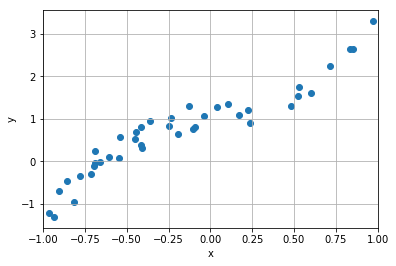

In [3]:
plt.scatter(xdat,ydat)
plt.xlim([-1,1])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

From this plot, you would have to find the relation $y \approx f(x)$.  

In this case, since the data was generated synthetically, we know "true" relation $y = f_0(x) + w$.    The code below plots the true relation on top of the scatter plot.  Of course, for "real" data, we would not know the true relation.  This is the advantage of synthetic data:  you can run a learning algorithm on the data and compare the estimated model to the true function.  

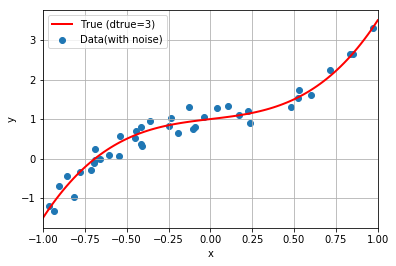

In [4]:
# Plot true function（without noise）
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
plt.xlim(-1,1)
plt.plot(xp,yp,'r-',linewidth=2.0)

# Plot the scatter plot of the measured data
plt.scatter(xdat,ydat)
plt.xlim([-1,1])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['True (dtrue=3)', 'Data(with noise)'], loc='upper left')
# plt.show()

## Fit Model of Different Model Orders

First, suppose that know the true model order  `d=3`, but then didn't know the coefficients of the model.  The coefficients could be estimated via linear regression using the linear regression methods in the `sklearn` package.  However, polynomial fitting can be directly performed via the the `polyfit` command.

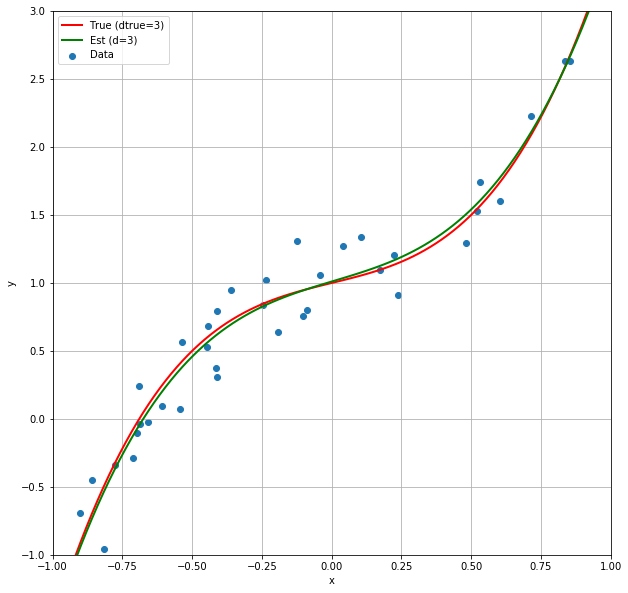

In [5]:
d = 3
beta_hat = poly.polyfit(xdat,ydat,d)


plt.figure(figsize=(10,10))
plt.figure(1) 
# Plot true and estimated function
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1,1)
plt.ylim(-1,3)
plt.plot(xp,yp,'r-',linewidth=2)
plt.plot(xp,yp_hat,'g-',linewidth=2)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['True (dtrue=3)', 'Est (d=3)', 'Data'], loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
# 因为noise每次都不一样，所以fit出的模型，画出来的线也会有区别


We see we get an excellent fit to the true function.  

But, in general, the model order `d` is not known.  So, it has to be estimated.   One idea is to use trial and error.  First, suppose we selected a model order that is too low, say $d=1$.

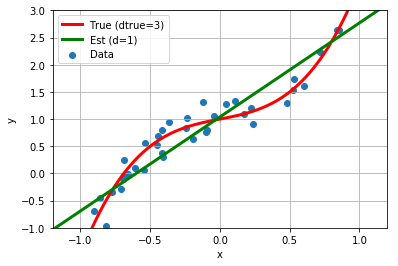

In [6]:
d = 1
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1.2,1.2,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1,1)
plt.ylim(-1,3)
plt.plot(xp,yp,'r-',linewidth=3)
plt.plot(xp,yp_hat,'g-',linewidth=3)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['True (dtrue=3)', 'Est (d=1)', 'Data'],loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1.2,1.2])
plt.show()


What we see is called *underfitting*.  The estimated function is not able to capture the full complexity of the relation between $x$ and $y$.  

Now suppose that we tried a model that was very high, say $d=10$.

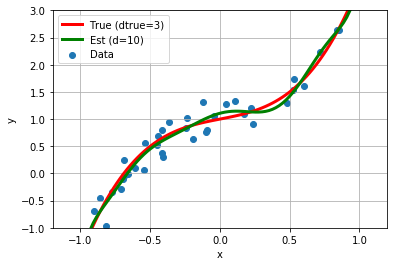

In [7]:
d = 10
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1.2,1.2,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1.2,1.2)
plt.ylim(-1,3)
plt.plot(xp,yp,'r-',linewidth=3)
plt.plot(xp,yp_hat,'g-',linewidth=3)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['True (dtrue=3)', 'Est (d=10)', 'Data'],loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1.2,1.2])
plt.show()

This is called *overfitting* and results is fitting the noise in the data and not the underlying relation $y=f(x)$.

When we compare the estimated function with the true function we can see the overfitting and underfittnig clearly.  But, in a real problem, we would not have access to the true function (otherwise, we wouldn't need to be estimating it).  The question then is if we can determine the correct model order from data.  

One (bad) idea is for each model order to  measure the RSS on the training data and select $d$ that minimizes the RSS.  To do this, the code below loops over a model order `d = 1,2,...,14` and for each model order, fits a model and measures the RSS.

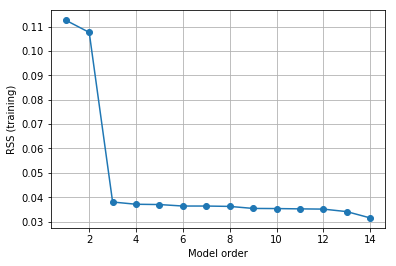

In [8]:
dtest = np.array(range(1,15))
RSStr = []
for d in dtest:
    
    # Fit data
    beta_hat = poly.polyfit(xdat,ydat,d)
    
    # Measure RSS on training data
    yhat = poly.polyval(xdat,beta_hat)
    RSSd = np.mean((yhat-ydat)**2)
    RSStr.append(RSSd)
    
plt.plot(dtest,RSStr,'o-')
plt.xlabel('Model order')
plt.ylabel('RSS (training)')
plt.grid()
    

We see that minimizing the RSS on the training data doesn't work:  As we increase $d$, the RSS always decreases.  So minimizing RSS on the training data leads to selecting a very high $d$ which in turn results in over-fitting.  How do we avoid this?



## Bias and Variance Visualized

To understand the tradeoffs in model order selection, we need to understand two key factors: *bias* and *variance*.  

First, we illustrate bias.  Qualitatively, *bias* is the difference between the true and estimated function that is due to the limitations of the model as distinct from the errors due to noise.  For linear estimation, the bias is equal to the difference between the estimate and true function when the noise is zero.   To illustrate this, the code below fits polynomial estimates for model orders `d=1,3,10` using the noise-free samples in each model order. The resulting estimates are plotted against the true function.

In [9]:
help(enumerate)

Help on class enumerate in module builtins:

class enumerate(object)
 |  enumerate(iterable[, start]) -> iterator for index, value of iterable
 |  
 |  Return an enumerate object.  iterable must be another object that supports
 |  iteration.  The enumerate object yields pairs containing a count (from
 |  start, which defaults to zero) and a value yielded by the iterable argument.
 |  enumerate is useful for obtaining an indexed list:
 |      (0, seq[0]), (1, seq[1]), (2, seq[2]), ...
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.



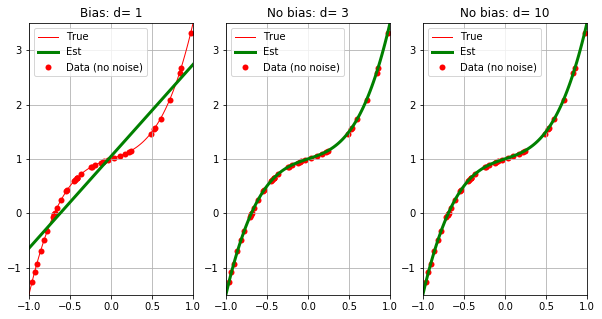

In [10]:
dtest = [1,3,10]  # Model orders to test
nd = len(dtest)

# Values to plot true for the true function
nplot = 100
xp = np.linspace(-1,1,nplot)
yp = poly.polyval(xp,beta)

# Estimates for each model
yp_hat = np.zeros((nplot,nd))
plt.figure(figsize=(10,5))

# enumerate 第一个返回值index，第二个为对应的value
for j, d in enumerate(dtest):
    # Fit the model on noise-free data y0
    beta_hat = poly.polyfit(xdat,y0,d)
    yp_hat[:,j] = poly.polyval(xp,beta_hat)
    
    # Plot the fit
    plt.subplot(1,nd,j+1)
    plt.xlim(-1,1)
    plt.ylim(-1.5,3.5)    
    plt.plot(xp,yp,'r-',linewidth=1)     
    plt.scatter(xdat,y0,marker='o',c='r',linewidth=0)
    plt.plot(xp,yp_hat[:,j],'g-',linewidth=3)
    if d < dtrue:
        plt.title('Bias: d= %d' % d)
    else:
        plt.title('No bias: d= %d' % d)        
    plt.grid()
    plt.legend(['True',  'Est', 'Data (no noise)'], loc='upper left')
    
# d=10的图，d>3的系数都为0


Now, recall the true model order is `dtrue=3`.  We see that when there is no noise, the estimate exactly matches the true function when `d >= dtrue`. In this case, the bias is zero.  In contrast, when `d < dtrue`, the model cannot capture the true function and significant bias is introduced.

Next, we attempt to understand the effect of noise.  For this purpose, we consider a theoretical set of repeated trials, where in each trial we imagine that there is a new training data set generated with indepdent noise. We then fit a model from the  training data and compute the mean and standard deviation of the estimate over the trials.

The code below runs 100 trials for the three different model orders: `d=1,3,14`.

In [11]:
ntrial = 100    # Number of trials
dtest = [1,3,14]  # Model orders to test
nd = len(dtest)

# Values to plot true for the true function
nplot = 30
xp = np.linspace(-1,1,nplot)
yp = poly.polyval(xp,beta)

# Mean and std deviation for each model order
yp_hat_mean = np.zeros((nplot,nd))
yp_hat_std  = np.zeros((nplot,nd))

for j, d in enumerate(dtest):
    # Values to plot for the estimated functions
    yp_hat = np.zeros((nplot,ntrial))

    for it in range(ntrial):

        # Generate new test data.  Only the noise is varying from one trial to the next
        ydati = y0 + np.random.normal(0,wstd,nsamp)  
        #y0 = poly.polyval(xdat,beta)
        #nsamp = 40

        # Fit the model
        beta_hat = poly.polyfit(xdat,ydati,d)   
        #xdat = np.random.uniform(-1,1,nsamp)
        yp_hat[:,it] = poly.polyval(xp,beta_hat)

    # Compute expectation and std deviation over the trials
    yp_hat_mean[:,j] = np.mean(yp_hat, axis=1) #axis=0每行对应位置相加；axis=1每列对应位置相加
    yp_hat_std[:,j] = np.std(yp_hat, axis=1)

Now, we plot the results.

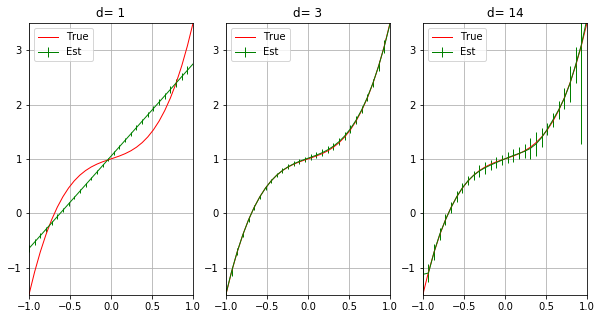

In [12]:
plt.figure(figsize=(10,5))
for j, d in enumerate(dtest):
    
    # Plot the fit
    plt.subplot(1,nd,j+1)   #共几行、共计列、第几个（从左到右从上到下编号）
    plt.xlim(-1,1)
    plt.ylim(-1.5,3.5)    
    plt.plot(xp,yp,'r-',linewidth=1) 
    #errorbar(Time,Average,Variance)



    plt.errorbar(xp,yp_hat_mean[:,j],fmt='g-',yerr=yp_hat_std[:,j],linewidth=1)
  
    
    plt.title('d= %d' % d)
    plt.grid()
    plt.legend(['True',  'Est'], loc='upper left')

We see that the mean values of the estimates are identical to the estimates we computed earlier on samples with no noise. Thus, if we could average over multiple independent training sets, it would have the effect of *averaging out the noise*.  This would only leave the *bias* error.  Hence, increasing the model still improves the *mean* estimate.  

But, we also see that the variance around those mean values increases with the model order.  Thus, on any particular trial, the estimated function could deviate significantly from the true function when the variance is high.

When there is noise, we define the *bias* as the difference between the true function and the mean estimate and the *variance* as the variance of the estimate around its mean.  In general, selecting the model order trades these two factors off:
* Increasing model order => Decreases bias.  
* Decreasing model order => Decreases variance.

## Using Cross-Validation

Our estimates for the model error must include both the bias and variance.  Measuring the error on the training data only measures the bias error. To evaluate both the model error including both the bias and variance, we need to evaluate the model on samples that were *not* used in training.  

One simple idea is cross validation:  We split the data into two components: (1) training and (2) test.  For now, let us split the data equally between the two parts.

In [13]:
# Number of samples for training and test
ntr = nsamp // 2  #  //表示只取整数部分，/表示保留小数的除法。nsamp = 40
nts = nsamp - ntr

# Training
xtr = xdat[:ntr]     #左闭右开
ytr = ydat[:ntr]    #带噪声

# Test
xts = xdat[ntr:]
yts = ydat[ntr:]
# xtr.shape ---20

Before we fit the data, let's plot the training and test samples separately.

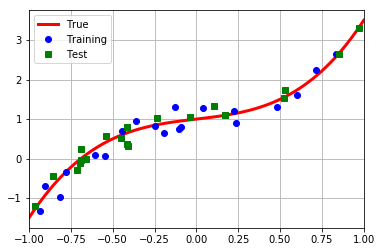

In [14]:
# Plot true function
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
plt.xlim(-1,1)
plt.plot(xp,yp,'r-',linewidth=3)

# Plot data
plt.plot(xtr,ytr,'bo')
plt.plot(xts,yts,'gs')
plt.grid()
plt.legend(['True','Training','Test'],loc='upper left')

#xdat是随机取，所以不是升序

Now we perform *cross-validation*:  For each model order $d$, we:

* Learn parameters $\hat{\beta}$ of order $d$ on the training data
* Predict the values on the test data
* Measure $RSS_{test}(d)$, the prediction error on the test data.

Select $d$ that minimizes $RSS_{test}(d)$.

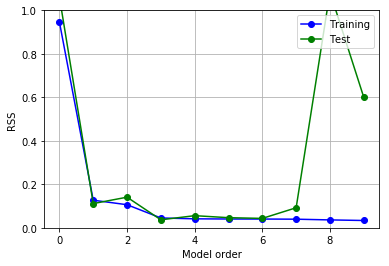

In [15]:
dtest = np.array(range(0,10))
RSStest = []
RSStr = []
for d in dtest:
    
    # Fit data
    beta_hat = poly.polyfit(xtr,ytr,d)
    
    # Measure RSS on training data
    # This is not necessary, but we do it just to show the training error
    yhat = poly.polyval(xtr,beta_hat)
    RSSd = np.mean((yhat-ytr)**2)
    RSStr.append(RSSd)
    
    # Measure RSS on test data
    yhat = poly.polyval(xts,beta_hat)
    RSSd = np.mean((yhat-yts)**2)
    RSStest.append(RSSd)
    
plt.plot(dtest,RSStr,'bo-')
plt.plot(dtest,RSStest,'go-')
plt.xlabel('Model order')
plt.ylabel('RSS')
plt.grid()
plt.ylim(0,1)
plt.legend(['Training','Test'],loc='upper right')
    

We select the model order from the minimum RSS on the test data

In [16]:
imin = np.argmin(RSStest)
print("Estimated model order= {0:d}".format(dtest[imin]))


Estimated model order= 3


## K-Fold Validation

There are two potential problems with the simple training / test split in the past example.
* We were only able to use a small number of samples (20 out of 40) for training the model
* The particular model and model order selection depends heavily on the particular samples you chose for the training.

Both of these issues are particularly problematic for data sets with small numbers of samples.  An improvement is to use k-fold validation.  In k-fold validation, we split the data into $k$ parts, each part being approximately equal in size.  In the example below, we will use $k=20$.  For each split, we fit the data on $k-1$ parts and test the data on the remaining part. Then, we average the score over the $k$ parts.  

The `sklearn` package has many routines for this purpose.  We begin by importing the `model_selection` sub-package.

In [17]:
import  sklearn.model_selection 

Then, we run the model validation.  Note that $k$-fold validation can be computationally expensive since we need to iterate over all the folds, and for each fold, we need to iterate over all the model orders.

In [18]:
# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(0,10)
nd = len(dtest)

# Loop over the folds
RSSts = np.zeros((nd,nfold))
for isplit, Ind in enumerate(kf.split(xdat)):
    #print (Ind)
    #Int是一个tuple数组（长度为10），第一个元素是xtr下标（36个），第二个是xts下标（4个）
    # Get the training data in the split
    Itr, Its = Ind
    xtr = xdat[Itr]
    ytr = ydat[Itr]
    xts = xdat[Its]
    yts = ydat[Its]
    
    for it, d in enumerate(dtest):
    
        # Fit data on training data
        beta_hat = poly.polyfit(xtr,ytr,d)
        
        # Measure RSS on test data
        yhat = poly.polyval(xts,beta_hat)
        RSSts[it,isplit] = np.mean((yhat-yts)**2)


Now, we compute the mean and standard error of the RSS over the folds for each model order.  The standard error is defined the standard deviation / $\sqrt{K-1}$, where $K$ is the number of folds.  We use $K-1$ instead of $K$ to remove the bias in the SE estimate.

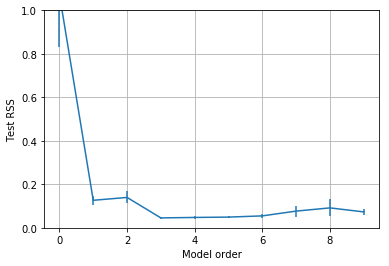

In [19]:
RSS_mean = np.mean(RSSts,axis=1)
RSS_std  = np.std(RSSts,axis=1) / np.sqrt(nfold-1)
plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='-')
plt.ylim(0,1)
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

Given these result, one method to select the model order is to use the model order that achieves the minimum mean RSS.  

In [20]:
imin = np.argmin(RSS_mean)
print("The selected model order is {0:d}".format(dtest[imin]))

The selected model order is 3


While this method may work in this data set, it sometimes selects a model order that is too high due to variance in the data.  A more conversative approach is the "one standard deviation" rule:
* Find the model order with the smallest `RSS_mean`
* Set `RSS_tgt` = minimum `RSS_mean` + one std error of the RSS at that minimum
* Find the lowest model order with `RSS < RSS_tgt`

This is illustrated in the following plot.

(array([3, 4, 5]),)
The estimated model order is 3


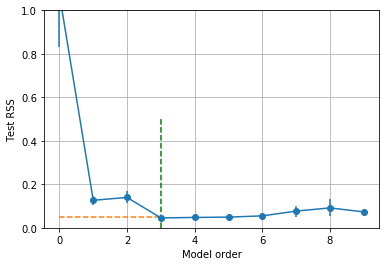

In [21]:
# Find the minimum RSS target
imin = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[imin] + RSS_std[imin]

# Find the lowest model order below the target
I = np.where(RSS_mean <= RSS_tgt)[0]
print(np.where(RSS_mean <= RSS_tgt))#  返回值是tuple
# print(RSS_mean )
# print(RSS_tgt)
# print(I)
iopt = I[0]
dopt = dtest[iopt]

plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='o-')

# Plot the line at the RSS target
plt.plot([dtest[0],dtest[imin]], [RSS_tgt, RSS_tgt], '--')

# Plot the line at the optimal model order
plt.plot([dopt,dopt], [0,0.5], 'g--')

plt.ylim(0,1)
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

# Print results
print("The estimated model order is %d" % dopt)